# BOOK: DYNAMIC MODE DECOMPOSITION- Data Driven Modelling of Complex Systems.

The core reason your Python code was initially not matching MATLAB and produced wrong eigenvalues with large reconstruction error is due to the different output structure of the SVD function between MATLAB and NumPy.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd

# =====================
# CREATE THE DATA
# =====================
xi = np.linspace(-10, 10, 400)
t = np.linspace(0, 4 * np.pi, 200)
dt = t[1] - t[0]
Xgrid, T = np.meshgrid(xi, t)

f1 = (1 / np.cosh(Xgrid + 3)) * (1 * np.exp(1j * 2.3 * T))
f2 = ((1 / np.cosh(Xgrid)) * np.tanh(Xgrid)) * (2 * np.exp(1j * 2.8 * T))
f = f1 + f2

X = f.T  # (space, time)

print(f"Shape of X: {X.shape}")

X1 = X[:, :-1]
X2 = X[:, 1:]

Shape of X: (400, 200)


In [ ]:
X1.shape

(400, 199)

In [ ]:
X2.shape

(400, 199)

In [ ]:
np.allclose(X1[:, 1:], X2[:, :-1])


True

In [ ]:
X1[:,-1],X2[:,-2]

(array([-1.45166537e-03-7.67916746e-04j, -1.52628494e-03-8.07389772e-04j,
        -1.60474016e-03-8.48891811e-04j, -1.68722816e-03-8.92527158e-04j,
        -1.77395625e-03-9.38405469e-04j, -1.86514237e-03-9.86642035e-04j,
        -1.96101568e-03-1.03735808e-03j, -2.06181709e-03-1.09068104e-03j,
        -2.16779993e-03-1.14674492e-03j, -2.27923051e-03-1.20569061e-03j,
        -2.39638886e-03-1.26766623e-03j, -2.51956939e-03-1.33282753e-03j,
        -2.64908165e-03-1.40133824e-03j, -2.78525107e-03-1.47337054e-03j,
        -2.92841984e-03-1.54910542e-03j, -3.07894772e-03-1.62873320e-03j,
        -3.23721297e-03-1.71245398e-03j, -3.40361327e-03-1.80047811e-03j,
        -3.57856675e-03-1.89302680e-03j, -3.76251303e-03-1.99033259e-03j,
        -3.95591430e-03-2.09263999e-03j, -4.15925653e-03-2.20020605e-03j,
        -4.37305064e-03-2.31330106e-03j, -4.59783381e-03-2.43220918e-03j,
        -4.83417081e-03-2.55722917e-03j, -5.08265544e-03-2.68867513e-03j,
        -5.34391199e-03-2.82687733e-03

In [ ]:
X1[-1].shape

(199,)

In [ ]:

# SVD and rank-2 truncation (CRITICAL: fix V matrix as below)
r = 2
U, s, Vh = svd(X1, full_matrices=False)
Ur = U[:, :r]                           # (space, r)
Sr = np.diag(s[:r])                     # (r, r)
Vr = Vh[:r, :].conj().T                 # (time-1, r) <- fix: not Vh.T, but Vh[:r, :].conj().T

print(f"Ur shape: {Ur.shape}")
print(f"Sr shape: {Sr.shape}")
print(f"Vr shape: {Vr.shape}")

Ur shape: (400, 2)
Sr shape: (2, 2)
Vr shape: (199, 2)


In [ ]:
# Build Atilde and DMD Modes
Atilde = Ur.T @ X2 @ Vr @ np.linalg.inv(Sr)
lambda_vals, W = np.linalg.eig(Atilde)
omega = np.log(lambda_vals) / dt

print("DMD eigenvalues (omega):")
for i, om in enumerate(omega):
    print(f" {om.real:8.4f} + {om.imag:8.4f}j")

Phi = X2 @ Vr @ np.linalg.inv(Sr) @ W

x1 = X[:, 0]
b = np.linalg.lstsq(Phi, x1, rcond=None)[0]

time_dynamics = np.zeros((r, len(t)), dtype=complex)
for iter in range(len(t)):
    time_dynamics[:, iter] = b * np.exp(omega * t[iter])

X_dmd = Phi @ time_dynamics

print("DMD reconstruction completed!")

DMD eigenvalues (omega):
   0.0000 +   2.8000j
  -0.0000 +   2.3000j
DMD reconstruction completed!


/tmp/ipython-input-1618244379.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


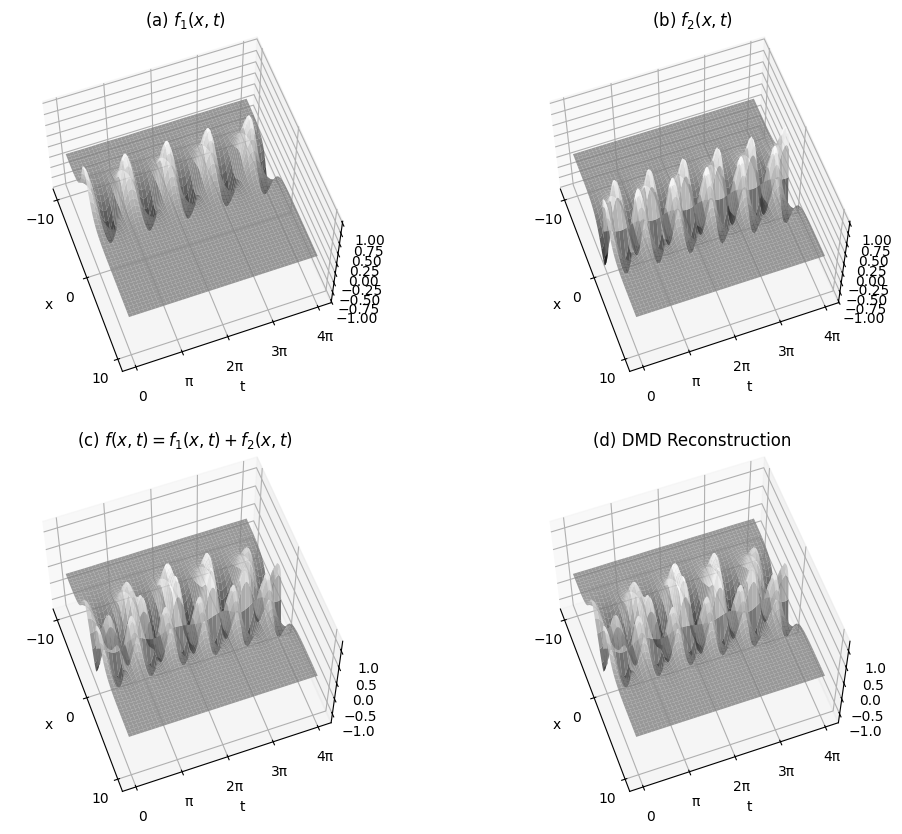


DMD RESULTS
DMD eigenvalues (omega):
   0.0000 +   2.8000j
  -0.0000 +   2.3000j

Expected: 0.0000 + 2.3000j and 0.0000 + 2.8000j

DMD Reconstruction Error: 5.43e-14
✅ DMD reconstruction is almost perfect!


In [ ]:
# Visualization
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.plot_surface(Xgrid, T, np.real(f1),
                 cmap='gray', linewidth=0, antialiased=True, alpha=0.8)
ax1.view_init(elev=60, azim=-20)
ax1.set_title('(a) $f_1(x,t)$')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_yticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi])
ax1.set_yticklabels(['0', 'π', '2π', '3π', '4π'])
ax1.set_xticks([-10, 0, 10])

ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.plot_surface(Xgrid, T, np.real(f2),
                 cmap='gray', linewidth=0, antialiased=True, alpha=0.8)
ax2.view_init(elev=60, azim=-20)
ax2.set_title('(b) $f_2(x,t)$')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_yticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi])
ax2.set_yticklabels(['0', 'π', '2π', '3π', '4π'])
ax2.set_xticks([-10, 0, 10])

ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.plot_surface(Xgrid, T, np.real(f),
                 cmap='gray', linewidth=0, antialiased=True, alpha=0.8)
ax3.view_init(elev=60, azim=-20)
ax3.set_title('(c) $f(x,t) = f_1(x,t) + f_2(x,t)$')
ax3.set_xlabel('x')
ax3.set_ylabel('t')
ax3.set_yticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi])
ax3.set_yticklabels(['0', 'π', '2π', '3π', '4π'])
ax3.set_xticks([-10, 0, 10])

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.plot_surface(Xgrid, T, np.real(X_dmd.T),
                 cmap='gray', linewidth=0, antialiased=True, alpha=0.8)
ax4.view_init(elev=60, azim=-20)
ax4.set_title('(d) DMD Reconstruction')
ax4.set_xlabel('x')
ax4.set_ylabel('t')
ax4.set_yticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi])
ax4.set_yticklabels(['0', 'π', '2π', '3π', '4π'])
ax4.set_xticks([-10, 0, 10])

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("DMD RESULTS")
print("=" * 60)
print("DMD eigenvalues (omega):")
for i, om in enumerate(omega):
    print(f" {om.real:8.4f} + {om.imag:8.4f}j")
print("\nExpected: 0.0000 + 2.3000j and 0.0000 + 2.8000j")
reconstruction_error = np.linalg.norm(X - X_dmd) / np.linalg.norm(X)
print(f"\nDMD Reconstruction Error: {reconstruction_error:.2e}")
if reconstruction_error < 0.01:
    print("✅ DMD reconstruction is almost perfect!")
else:
    print("❌ DMD reconstruction has significant error")
